In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision import transforms, utils
from PIL import Image
from torch import optim

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [3]:
class Dataset(data.Dataset):
    def __init__(self, gross, train = True, transform = None):
        self.gross = gross
        self.train = train
        self.transform = transform
        self.random_coor = torch.rand(self.gross, 2)*1.6-0.8
        
    def __len__(self):
        return self.gross
    
    def __getitem__(self, index):
        X = cv2.imread(os.path.join('data', '{:05d}_0.jpeg'.format(index+1)))[:256, :256, ::-1]
        X = cv2.resize(X, (0,0), fx=0.5, fy=0.5) 
        hole_coor = self.random_coor[index]
        if self.transform:
            X = self.transform(X)
        

        return X, hole_coor

In [4]:
trainingset = Dataset(400, transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(128),
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
params = {'batch_size':16, 'shuffle':True, 'num_workers':4}
traininggen = data.DataLoader(trainingset, **params)

In [5]:
def makeHole(imgT, locationT, size = 30):
    B, C, H, W = imgT.size()
    lx = (locationT[:, 0]+1)*H/2
    ly = (locationT[:, 1]+1)*W/2
    holeimg = imgT.clone()
    a = torch.clamp(lx-size, min = 0).int()
    b = torch.clamp(lx+size, max = H).int()
    c = torch.clamp(ly-size, min = 0).int()
    d = torch.clamp(ly+size, max = W).int()
    for i in range(B):
        holeimg[i, :, a[i]:b[i], c[i]:d[i]]=-1
    return holeimg

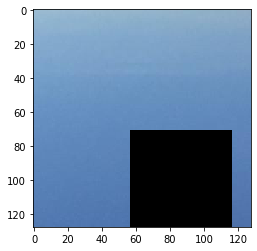

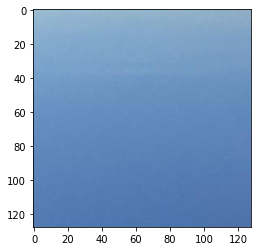

In [6]:
for X, hole_coor in traininggen:
    XX = makeHole(X, locationT = hole_coor)
    plt.imshow(XX[3].numpy().transpose(1, 2, 0)/2+0.5)
    plt.show()
    plt.imshow(X[3].numpy().transpose(1, 2, 0)/2+0.5)
    plt.show()
    break

In [7]:
class net(nn.Module):
    
    def __init__(self):
        super(net, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 32, 7, stride =2, padding=3)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 5, stride =2, padding=2)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 5, stride =2, padding=2)
        self.bn4 = nn.BatchNorm2d(64)
        torch.nn.init.kaiming_normal_(self.conv1.weight)
        torch.nn.init.kaiming_normal_(self.conv2.weight)
        torch.nn.init.kaiming_normal_(self.conv3.weight)
        torch.nn.init.kaiming_normal_(self.conv4.weight)
        self.fc1 = nn.Linear(8*8*64, 100)
        self.fc2 = nn.Linear(100, 2)
        
    def forward(self, x, ref):
        t = self.bn1(F.relu(self.conv1(x)))
        t = self.bn2(F.relu(self.conv2(t)))      
        t = self.bn3(F.relu(self.conv3(t)))
        t = self.bn4(F.relu(self.conv4(t)))
        t = F.relu(self.fc1(t.view(t.size()[0], -1)))
        mu = torch.tanh(self.fc2(t))      
        noise = torch.zeros_like(mu)
        noise.data.normal_(std = 0.17)
        l = mu + noise
        l = torch.tanh(l)
        log_pi = torch.distributions.Normal(mu, 0.1).log_prob(l)
        log_pi = torch.sum(log_pi, dim=1)
        x =  self.look(ref, l)
        
        return x, l, log_pi
    
    def look(self, imgT, locationT, size = 25):
        ## imgT is 4 dim
        ## locationT is 2 dim Bx2
        B, C, H, W = imgT.size()

        x_idx = (locationT[:, 0]+1)*H/2
        y_idx = (locationT[:, 1]+1)*W/2
        holeimg = - torch.ones_like(imgT)
        a = torch.clamp(x_idx-size, min = 0).int()
        b = torch.clamp(x_idx+size, max = H).int()
        c = torch.clamp(y_idx-size, min = 0).int()
        d = torch.clamp(y_idx+size, max = W).int()
        for i in range(B):
            holeimg[i, :, a[i]:b[i], c[i]:d[i]]=imgT[i, :, a[i]:b[i], c[i]:d[i]]
        return holeimg

        return lookNext

In [8]:
def get_parameter_number(net):
    total_num = sum(p.numel() for p in net.parameters())
    trainable_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
    return {'Total': total_num, 'Trainable': trainable_num}

In [9]:
model = net().to(device)

In [10]:
print(model)
get_parameter_number(model)

net(
  (conv1): Conv2d(3, 8, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4096, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)


{'Total': 577726, 'Trainable': 577726}

In [11]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

In [12]:
def plotImage(tensorList):
    fig, ax = plt.subplots(1, len(tensorList), figsize=(8, 6))
    for i, tensor in enumerate(tensorList):
        if use_cuda:
            tensor = tensor.cpu()
        ax[i].imshow(tensor.numpy().transpose(1, 2, 0)/2+0.5)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


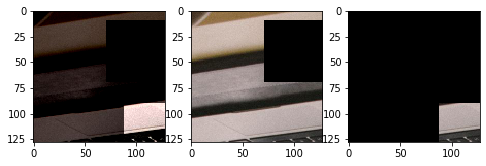

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


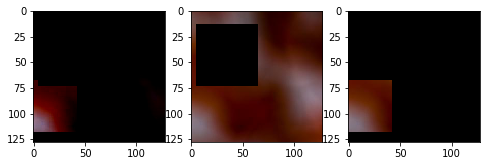

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


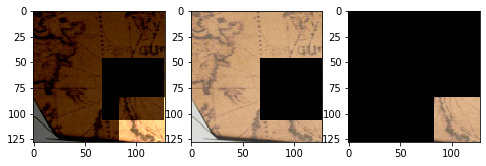

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


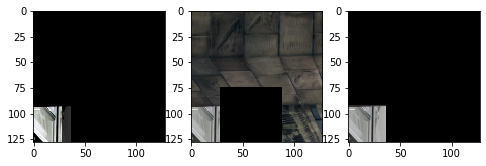

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


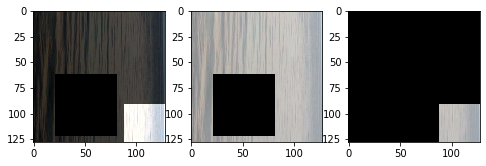

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


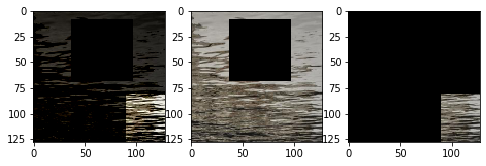

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


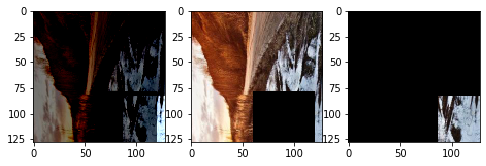

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


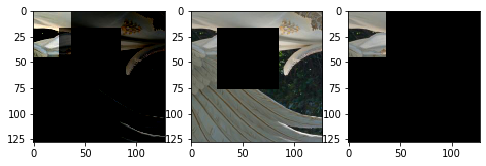

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


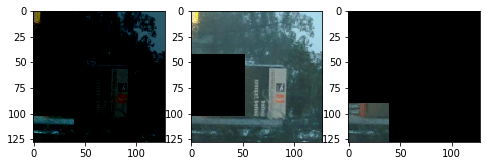

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


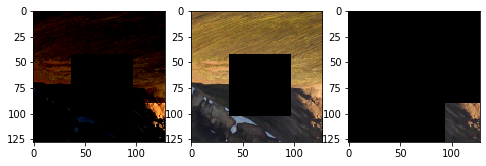

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


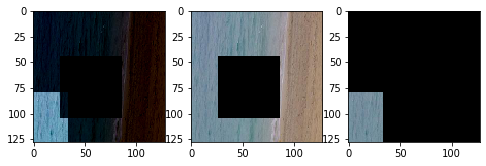

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


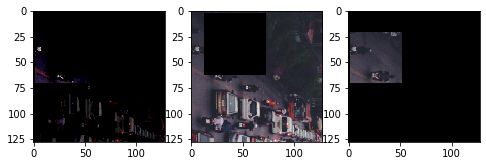

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


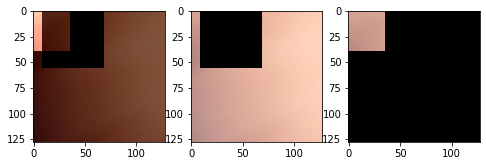

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


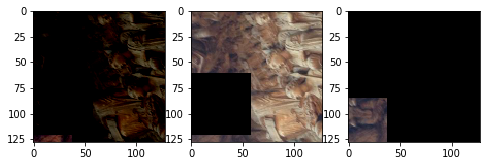

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


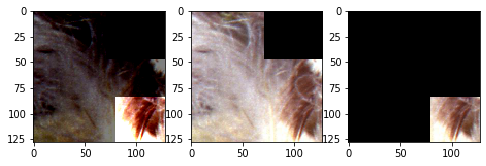

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


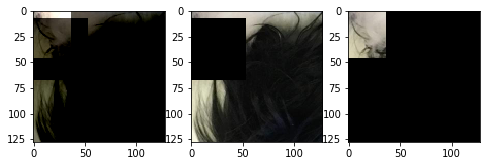

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


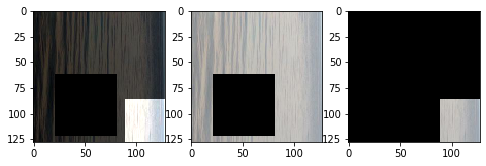

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


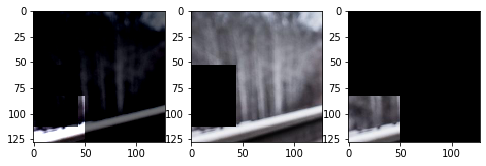

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


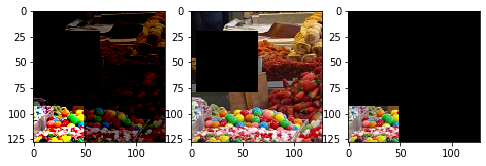

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


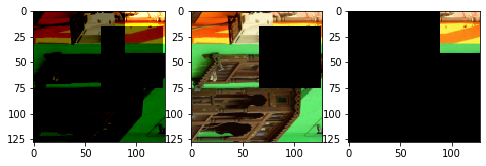

In [48]:
model.train()

running_loss = 0.0

for epoch in range(200):
    
    for k, (X, hole_coor) in enumerate(traininggen, 0):
        optimizer.zero_grad()
        log_pi = []
        X = X.to(device)

        XX = makeHole(X, locationT = hole_coor)

        for i in range(1):
            x, l, p = model(XX, X)
            log_pi.append(p)
            
#         print(l[3])
        
        log_pi = torch.stack(log_pi).transpose(1, 0)

        R = -torch.mean((x + XX - X)**2, [1, 2, 3])
        R = R.unsqueeze(1).repeat(1, 1)

    #    loss_baseline = F.mse_loss(baselines, R)
        adjusted_reward = 100*(R + 1.12)# - baselines.detach() + 

        loss_reinforce = torch.sum(-log_pi*adjusted_reward, dim=1)
        loss_reinforce = torch.mean(loss_reinforce, dim=0)
        loss = loss_reinforce#+loss_baseline
        running_loss += loss
        loss.backward()
#         if k % 50 == 49:
#         print('[%d %5d] loss: %.3f' %
#               (epoch+1, k + 1, running_loss), end='')
#         print("   current reward: {:.5f}".format(adjusted_reward.mean().item()))
        running_loss = 0.0

        optimizer.step()
        
    if epoch %10 == 9:
        idx = 3
        plotImage([x[idx]+XX[idx], XX[idx], x[idx]])


In [14]:
# model.train()

# running_loss = 0.0

# for epoch in range(50):
    
#     for k, (X, hole_coor) in enumerate(traininggen, 0):
#         optimizer.zero_grad()
#         log_pi = []
#         X = X.to(device)

#         XX = makeHole(X, locationT = hole_coor)

#         x, l, p = model(XX, X)
            
#         loss = F.mse_loss(hole_coor.to(device), l)
#         loss.backward()
#         running_loss+=loss.item()
#         optimizer.step()
        
#     print(epoch, "    ", running_loss)
#     running_loss= 0.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


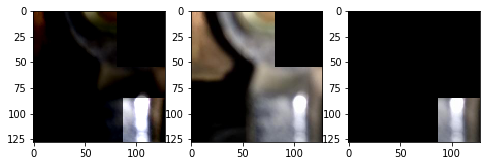

In [15]:
idx = 11
plotImage([x[idx]+XX[idx], XX[idx], x[idx]])

In [45]:
a = model.fc2.weight

In [46]:
a.size()

torch.Size([2, 100])

In [47]:
print(a.max())
print(a.min())

tensor(0.1271, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-0.1276, device='cuda:0', grad_fn=<MinBackward1>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


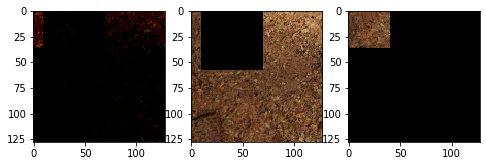

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


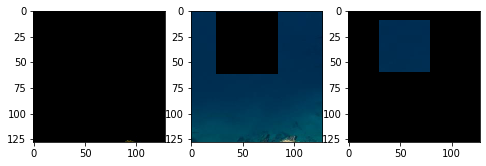

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


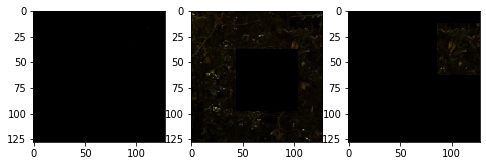

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


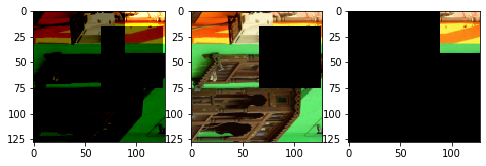

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


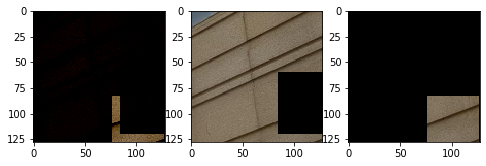

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


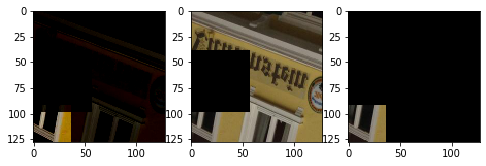

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


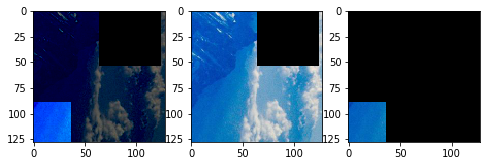

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


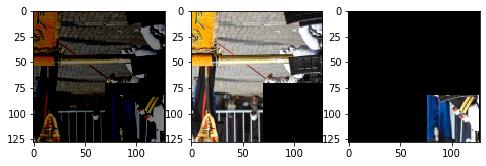

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


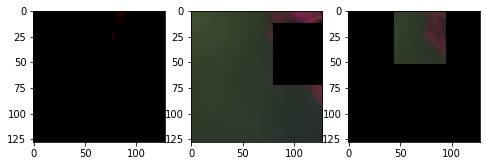

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


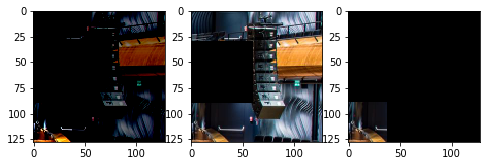

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


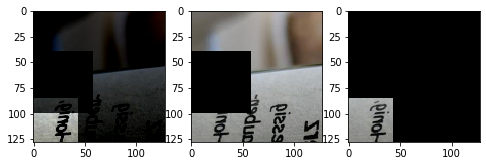

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


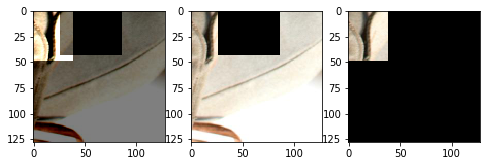

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


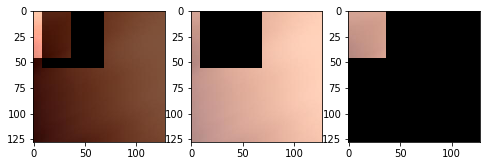

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


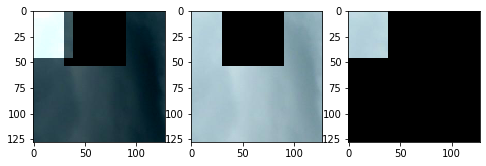

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


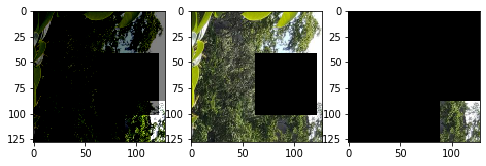

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


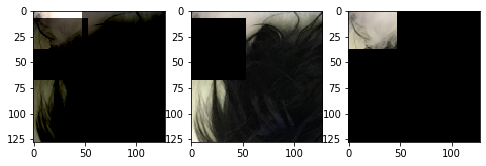

In [51]:
for idx in range(16):
    plotImage([x[idx]+XX[idx], XX[idx], x[idx]])